<a href="https://colab.research.google.com/github/nargesalavi/QAOA-for-MAXCUT/blob/main/QAOA_for_MaxCut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QAOA for MaxCut

In [ ]:
!pip install qiskit

In [4]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

In this notebook, we implement the Quantum Approximate Optimization Algorithm (QAOA) to solve the MaxCut problem, as proposed in [Farhi et. al.](https://arxiv.org/abs/1411.4028) 

In [5]:
import numpy as np
import networkx as nx  # tool to handle general Graphs 
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from qiskit import Aer, IBMQ, execute
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

In [6]:
from qiskit.aqua.operators.primitive_ops import CircuitOp
from qiskit.aqua import QuantumInstance
from qiskit.aqua.operators import PauliExpectation, CircuitSampler, StateFn
from qiskit.aqua.operators.state_fns import CircuitStateFn

from qiskit.aqua.components.optimizers import ADAM

In [83]:
import networkx as nx

from qiskit.circuit.library import TwoLocal
from qiskit.optimization.applications.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import aqua_globals
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging

In the MaxCut problem, we try to find a cut to divide nodes into two sets in a way that the number of edges from one set to another set is maximum. Note that here we consider unweighted graphs. 

Assume that we have $v$ vertices and $e$ edges. The following equation is the one we want to maximize in the MaxCut problem

$C(z) = \sum_{i = 1}^e C_i(z)$

where $z=z_1z_2 ...z_v$ is a bitstring that shows the cut. If $z_i = 0$, the $i^{th}$ vertex is in the first set of the cut; otherwise, it is in the second set.


In the following block you can find how a random graph is implemented.

[(0, 3, 1.0), (0, 4, 1.0), (0, 5, 1.0), (0, 6, 1.0), (0, 7, 1.0), (0, 8, 1.0), (0, 9, 1.0), (0, 10, 1.0), (1, 1, 1.0), (1, 5, 1.0), (1, 6, 1.0), (1, 7, 1.0), (1, 8, 1.0), (2, 4, 1.0), (2, 7, 1.0), (2, 9, 1.0), (3, 3, 1.0), (3, 5, 1.0), (3, 7, 1.0), (3, 10, 1.0), (4, 4, 1.0), (4, 5, 1.0), (4, 7, 1.0), (4, 8, 1.0), (4, 10, 1.0), (4, 11, 1.0), (5, 5, 1.0), (5, 6, 1.0), (5, 8, 1.0), (5, 10, 1.0), (6, 8, 1.0), (6, 9, 1.0), (6, 10, 1.0), (7, 8, 1.0), (7, 10, 1.0), (7, 11, 1.0), (8, 10, 1.0), (8, 11, 1.0), (9, 11, 1.0), (10, 10, 1.0)]


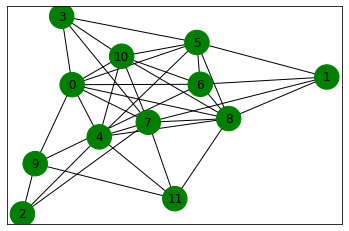

In [7]:
number_of_vertices = 12
vertices = np.arange(0,number_of_vertices,1)
edges = []
for i in range (0,number_of_vertices):
    for j in range(i,number_of_vertices):
        if np.random.random() < 0.5:
            continue
        else:
            edges.append((i,j,1.0))
#edges =[(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0)] 
print(edges)
G = nx.Graph()
G.add_nodes_from(vertices)
G.add_weighted_edges_from(edges)

# Generate plot of the Graph
colors       = ['g' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

Let us first start with a smaller graph with 3 nodes and 2 edges.

In [33]:
n_qubits = 3
n_layers = 1
edges =[(1, 0), (1, 2)]

### QAOA Circuit

To have an intuition about how the QAOA circuit solves the MaxCut problem, one can say that QAOA finds the bitstring $z$ that maximize $C(z)$. To do so, we have to start with the quantum state $|+_v> = 1/\sqrt(2^v) \sum_{z=0}^{2^v} |z>$ which has all the possible bitstring with equal probability amplitudes. Then by applying parameterized gates, appropriate operators, and exploiting optimization methods, we will increase the probability amplitude of the $|z>$ that maximizes $C(z)$.

Therefore, we can represent the term in the objective function as

$C_i = 1/2 (1 - z^iz^k)$

that edge $i$ is between nodes $(j,k)$. Each vertex is mapped to a qubit. Hence, $C_i$ has eigenvalue equals to 1 if and only if these two qubits $j$ and $k$ have a different z-measurement results. Therefore, we calculate the expectation value of $ZZ$ operators between any two qubits $j$ and $k$ that $(j,k) \in Edge set$.

We also need to utilize parameterized gates. U_beta is $R_x$ and U_gamma is Ising coupling gate between the qubits that in the graph are connected together via an edge. We can have different number of layers of these variational gates that can results in a better approximation of the MaxCut solution, with the cost of increasing the optimization time and using more gates. Here we consider one-layer implementation.

In [9]:
'''MY CODE'''
# prepare the quantum and classical resisters

def U_initial_state():
  for q in range(n_qubits):
    qaoa_circuit.h(q)

def U_beta(beta):
  for q in range(n_qubits):
    qaoa_circuit.rx(2 * beta, q)

def U_gamma(gamma):
  for edge in edges:
    q1 = edge[0]
    q2 = edge[1]
    qaoa_circuit.cx(q1, q2)
    qaoa_circuit.rz(gamma,q2)
    qaoa_circuit.cx(q1, q2)

def measurement_op(edge):
  c = QuantumCircuit(n_qubits)
  q1 = edge[0]
  q2 = edge[1]
  c.z(q1)
  c.z(q2)

  op = CircuitOp(c)
  return op

def psi_state(params):
  U_initial_state()
  U_beta(init_params[0])
  U_gamma(init_params[1])

In [57]:
'''MY CODE'''

backend = Aer.get_backend('qasm_simulator') 

def calc_expectation(op, psi):
  q_instance = QuantumInstance(backend, shots=100)

  # define the state to sample
  measurable_expression = StateFn(op, is_measurement=True).compose(psi) 
  # convert to expectation value
  expectation = PauliExpectation().convert(measurable_expression)  

  # get state sampler (you can also pass the backend directly)
  sampler = CircuitSampler(q_instance).convert(expectation) 
  return sampler


For instance, here you can see the QAOA circuit and the Z operators for edge (1,0).

In [36]:
import warnings
warnings.filterwarnings('ignore')

import logging, sys
logging.disable(sys.maxsize)

qaoa_circuit = QuantumCircuit(n_qubits)
params = 0.01 * np.random.rand(2, n_layers)
psi_state(params)
psi = CircuitStateFn(qaoa_circuit)

op = measurement_op(edges[0])
print(psi + op)

SummedOp([
  CircuitStateFn(
       ┌───┐┌────┐┌───┐┌────┐┌───┐                
  q_0: ┤ H ├┤ RX ├┤ X ├┤ RZ ├┤ X ├────────────────
       ├───┤├────┤└─┬─┘└────┘└─┬─┘                
  q_1: ┤ H ├┤ RX ├──■──────────■────■──────────■──
       ├───┤├────┤                ┌─┴─┐┌────┐┌─┴─┐
  q_2: ┤ H ├┤ RX ├────────────────┤ X ├┤ RZ ├┤ X ├
       └───┘└────┘                └───┘└────┘└───┘
  ),
       ┌───┐
  q_0: ┤ Z ├
       ├───┤
  q_1: ┤ Z ├
       └───┘
  q_2: ─────
            
])


Then, gradient descent is used to optimize the objective function.

In [59]:
import warnings
warnings.filterwarnings('ignore')

import logging, sys
logging.disable(sys.maxsize)

learning_rate = 0.1
#def QAOA_MaxCut_Solver(n_layers=1):
print("\np={:d}".format(n_layers))

# initialize the parameters near zero
init_params = np.random.rand(2, n_layers)
qaoa_circuit = None
epsilon = 0.1
# minimize the negative of the objective function
def objective(params):
    neg_obj = 0
    global qaoa_circuit 
    for edge in edges:
      #print('EDGE:', edge)
      
      qaoa_circuit = QuantumCircuit(n_qubits)
      psi_state(params)
      psi = CircuitStateFn(qaoa_circuit)

      op = measurement_op(edge)

      sampler = calc_expectation(op, psi)

      #print('****************',sampler.eval().real)
      # objective for the MaxCut problem
      neg_obj -= 0.5 * (1 -  sampler.eval().real)

    return neg_obj

# initialize optimizer: Adagrad works well empirically
opt = ADAM()

# optimize parameters in objective
params = init_params
steps = 100

for i in range(steps):
    #grads = opt.gradient_num_diff(params,objective,np.pi/8)
    if i > 20:
      learning_rate = learning_rate/10
    grad0 = (objective(params + [[epsilon],[0.0]]) - objective(params - [[0.0],[epsilon]]))/(2*epsilon)
    grad1 = (objective(params - [[0.0],[epsilon]]) - objective(params - [[0.0],[epsilon]]))/(2*epsilon)
    #print('Params:',  params, 'Grads', grads)
    #print("VVVVV", grad0, grad1, params)
    params[0] -=learning_rate*grad0#grads[0]
    params[1] -=learning_rate*grad1#grads[1]
    if (i + 1) % 5 == 0:
        print("Objective after step {:5d}: {: .7f}".format(i + 1, -objective(params)))
#a = opt.optimize(2*n_layers,objective)
print(-objective(params),params)
#print(a)
    #return -objective(params),params


p=1
Objective after step     5:  1.0400000
Objective after step    10:  0.9900000
Objective after step    15:  0.9700000
Objective after step    20:  0.9100000
Objective after step    25:  0.9600000
Objective after step    30:  0.9600000
Objective after step    35:  1.0700000
Objective after step    40:  0.9500000
Objective after step    45:  0.9500000
Objective after step    50:  0.9200000
Objective after step    55:  1.0300000
Objective after step    60:  1.0200000
Objective after step    65:  1.0400000
Objective after step    70:  0.9300000
Objective after step    75:  1.0300000
Objective after step    80:  0.9500000
Objective after step    85:  1.1600000
Objective after step    90:  1.0800000
Objective after step    95:  0.9300000
Objective after step   100:  0.9700000
0.97 [[0.19716481]
 [0.28894457]]


In [61]:
import warnings
warnings.filterwarnings('ignore')
backend_sim = Aer.get_backend("qasm_simulator")
shots = 10000
print(params)
qaoa_circuit = QuantumCircuit(n_qubits)
psi_state(params)
meas = QuantumCircuit(n_qubits, n_qubits)
meas.measure(range(n_qubits), range(n_qubits))
qaoa_circuit.barrier()
qaoa_circuit = qaoa_circuit + meas
qaoa_circuit.draw()


[[0.19716481]
 [0.28894457]]


┌───┐┌────┐┌───┐┌────┐┌───┐                 ░ ┌─┐      
q_0: ┤ H ├┤ RX ├┤ X ├┤ RZ ├┤ X ├─────────────────░─┤M├──────
     ├───┤├────┤└─┬─┘└────┘└─┬─┘                 ░ └╥┘┌─┐   
q_1: ┤ H ├┤ RX ├──■──────────■────■──────────■───░──╫─┤M├───
     ├───┤├────┤                ┌─┴─┐┌────┐┌─┴─┐ ░  ║ └╥┘┌─┐
q_2: ┤ H ├┤ RX ├────────────────┤ X ├┤ RZ ├┤ X ├─░──╫──╫─┤M├
     └───┘└────┘                └───┘└────┘└───┘ ░  ║  ║ └╥┘
c: 3/═══════════════════════════════════════════════╩══╩══╩═
                                                    0  1  2

In [64]:
job_sim = execute(qaoa_circuit, backend_sim, shots=10000)
result_sim = job_sim.result()

counts = result_sim.get_counts(qaoa_circuit)
print(counts.most_frequent())

101


Unfortunately, these implementations could not result in the desired solution. During the optimization via gradient descent, it seems that it cannot converge to the optimal value. One reason can be the function calc_expectation that is the bottleneck of the implementation. 

Although the QAOA function in the Qiskit can perfectly approximate the solutions of the Maxcut, let us utilize VQE and Quadratic Programming in Qiskit to implement QAOA.

In [108]:
aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

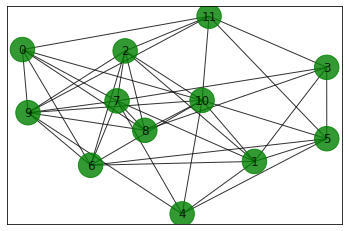

In [109]:
v=12 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,v,1))
edges = []
#elist=[(1,0,1.0),(1,2,1.0),(1,3,1.0),(1,4,1.0),(1,5,1.0),(1,6,1.0),(1,7,1.0),(1,8,1.0),(1,9,1.0),(1,10,1.0),(1,11,1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
for i in range (0,v):
    for j in range(i,v):
        if np.random.random() < 0.5:
            continue
        else:
            edges.append((i,j,1.0))

G.add_weighted_edges_from(edges)

colors = ['g' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G,'color')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

The above figure shows a random graph with 12 nodes.

Let us first find the solution of the MaxCut for this graph via brute force searching.

In [110]:
# Computing the graph matrix
def graph_matrix():
  g_matrix = np.zeros([v,v])
  for i in range(v):
      for j in range(v):
          temp = G.get_edge_data(i,j,default=0)
          if temp != 0:
              g_matrix[i,j] = temp['weight']
  return g_matrix

In [111]:
g_matrix = graph_matrix()
print(g_matrix)

[[1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0.]
 [0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1.]
 [0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0.]
 [0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1.]
 [1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0.]
 [1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0.]]


Here we search through all the possible $2^{12}$ cuts to find the maximum cut.

In [112]:
def brute_force():
  max_cost = 0
  for b in range(2**v):
      x = [int(t) for t in reversed(list(bin(b)[2:].zfill(v)))]
      cost = 0
      for i in range(v):
          for j in range(v):
              cost = cost + g_matrix[i,j]*x[i]*(1-x[j])
      if max_cost < cost:
          max_cost = cost
          xbest_brute = x

  colors = ['r' if xbest_brute[i] == 0 else 'c' for i in range(v)]
  draw_graph(G, colors, pos)

  return xbest_brute, max_cost

Brute force solution = [1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0] cost = 27.0


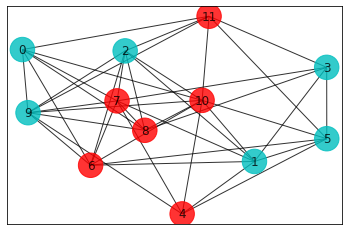

In [113]:
xbest_brute, max_cost = brute_force()
print('Brute force solution = ' + str(xbest_brute) + ' cost = ' + str(max_cost))

Now, let us implement this graph on a quantum circuit. The same as what we did on the previous implementation, we should generate the Ising hamiltonian based on the edges of the graph. Here max_cut.get_operator is used for generating the Ising models.

In [114]:
ops, offset = max_cut.get_operator(g_matrix)
print('Ising Hamiltonian:')
print(ops.print_details())

Ising Hamiltonian:
IIIIIIIIIZZI	(0.5+0j)
IIIIIIIIZIZI	(0.5+0j)
IIIIIIIZIIZI	(0.5+0j)
IIIIIIZIIIZI	(0.5+0j)
IIIIIIZIZIII	(0.5+0j)
IIIIIIZZIIII	(0.5+0j)
IIIIIZIIIIIZ	(0.5+0j)
IIIIIZIIIIZI	(0.5+0j)
IIIIIZIIIZII	(0.5+0j)
IIIIIZZIIIII	(0.5+0j)
IIIIZIIIIIIZ	(0.5+0j)
IIIIZIIIIIZI	(0.5+0j)
IIIIZIIIIZII	(0.5+0j)
IIIIZIIIZIII	(0.5+0j)
IIIIZIIZIIII	(0.5+0j)
IIIIZZIIIIII	(0.5+0j)
IIIZIIIIIIIZ	(0.5+0j)
IIIZIIIIIZII	(0.5+0j)
IIIZIIIIZIII	(0.5+0j)
IIIZZIIIIIII	(0.5+0j)
IIZIIIIIIIIZ	(0.5+0j)
IIZIIIIIIZII	(0.5+0j)
IIZIIIIZIIII	(0.5+0j)
IIZIIZIIIIII	(0.5+0j)
IIZIZIIIIIII	(0.5+0j)
IIZZIIIIIIII	(0.5+0j)
IZIIIIIIIIIZ	(0.5+0j)
IZIIIIIIIIZI	(0.5+0j)
IZIIIIIIIZII	(0.5+0j)
IZIIIIIZIIII	(0.5+0j)
IZIIIIZIIIII	(0.5+0j)
IZIIIZIIIIII	(0.5+0j)
IZIZIIIIIIII	(0.5+0j)
IZZIIIIIIIII	(0.5+0j)
ZIIIIIIIIIIZ	(0.5+0j)
ZIIIIIIIIZII	(0.5+0j)
ZIIIIIIIZIII	(0.5+0j)
ZIIIIIZIIIII	(0.5+0j)
ZIZIIIIIIIII	(0.5+0j)
ZZIIIIIIIIII	(0.5+0j)



Here we use the VQE, implemented in Qiskit, and apply the operators to find the maximum cut.

In [115]:
def QAOA_via_VQE(ops):
  spsa = SPSA(maxiter=300)
  ry = TwoLocal(ops.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
  vqe = VQE(ops, ry, spsa, quantum_instance=quantum_instance)

  # run VQE
  result = vqe.run(quantum_instance)

  return result

In [116]:
result = QAOA_via_VQE(ops)
# print results
x = sample_most_likely(result.eigenstate)
print('Optimization Time:', result.optimizer_time)
print('max-cut objective:', result.eigenvalue.real + offset)
print('Solution:', max_cut.get_graph_solution(x))

Optimization Time: 104.87271785736084
max-cut objective: -26.253791550876347
Solution: [0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1.]


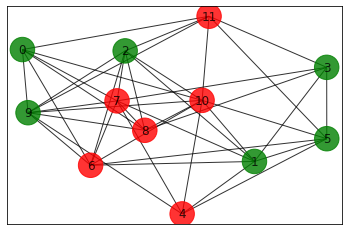

In [117]:
# plot results
colors = ['g' if max_cut.get_graph_solution(x)[i] == 0 else 'r' for i in range(v)]
draw_graph(G, colors, pos)

Let us also check a simpler 12-node graph.

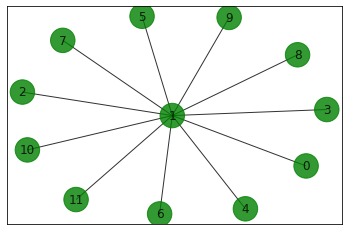

In [118]:
v=12 # Number of nodes in graph
G=nx.Graph()
G.add_nodes_from(np.arange(0,v,1))
edges = []
edges=[(1,0,1.0),(1,2,1.0),(1,3,1.0),(1,4,1.0),(1,5,1.0),(1,6,1.0),(1,7,1.0),(1,8,1.0),(1,9,1.0),(1,10,1.0),(1,11,1.0)]
G.add_weighted_edges_from(edges)
colors = ['g' for node in G.nodes()]
pos = nx.spring_layout(G)
draw_graph(G, colors, pos)

In [119]:
g_matrix = graph_matrix()

Brute force solution = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] cost = 11.0


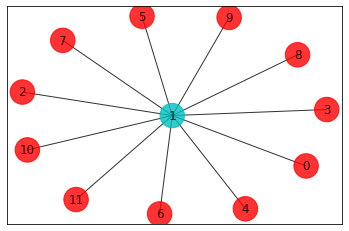

In [120]:
xbest_brute, max_cost = brute_force()
print('Brute force solution = ' + str(xbest_brute) + ' cost = ' + str(max_cost))

In [121]:
ops, offset = max_cut.get_operator(g_matrix)

In [122]:
result = QAOA_via_VQE(ops)
# print results
x = sample_most_likely(result.eigenstate)
print('Optimization Time:', result.optimizer_time)
print('max-cut objective:', result.eigenvalue.real + offset)
print('Solution:', max_cut.get_graph_solution(x))

Optimization Time: 81.69514417648315
max-cut objective: -10.26184537973307
Solution: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


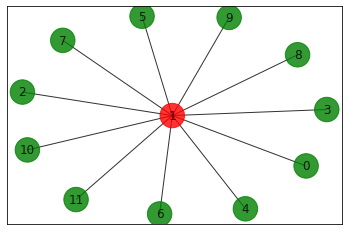

In [123]:
# plot results
colors = ['g' if max_cut.get_graph_solution(x)[i] == 0 else 'r' for i in range(v)]
draw_graph(G, colors, pos)

The above codes for solving MaxCut via VQE, implemented in Qiskit, are based on the codes provided by Qiskit, the link mentioned in the references.

#### References
[Solving combinatorial optimization problems using QAOA, Qiskit](https://qiskit.org/textbook/ch-applications/qaoa.html).

[Max-Cut and Traveling Salesman Problem, Qiskit](https://qiskit.org/documentation/tutorials/optimization/6_examples_max_cut_and_tsp.html?highlight=qiskit.aqua%20import%20operator)

[Intro to QAOA, Xanadu](https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html)

[QAOA for MaxCut, Xanadu](https://pennylane.ai/qml/demos/tutorial_qaoa_maxcut.html)

